### 1. Import Libraries

In [86]:
import pandas as pd # pandas is ised to load and manipulate data and for One-Hot Encoding
import numpy as np # data manipulation
import matplotlib.pyplot as plt # matplotlib is for drawing graphs
import matplotlib.colors as colors # 
from sklearn.utils import resample # downsample the dataset
from sklearn.model_selection import train_test_split # split data into training and testing sets
from sklearn.preprocessing import scale # scale and center data
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC # support vector machine classification
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # cross validation
from sklearn.metrics import confusion_matrix # create confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay # draw confusion matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA # perform PCA to plot the data

from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm

import pickle  
import joblib 


# import matlab data
from scipy.io import loadmat

### 2. Import the Data

##### 2.1 Load the .mat file (input) and .csv file (output)

In [87]:
subject = int(input('subject: '))

# [INPUT: EEG & ECG data] load the .mat file

data = loadmat(f'C:/Users/Natchira/Documents/M.eng (from hp)/Thesis/OpenViBE/EEG_ECG_Features/EEG_ECG_Features_subject{subject}.mat')
ECG_features = data['ECG_features']
EEG_features = data['EEG_features']

# [OUTPUT: ORD] load the .csv file
# ord_60min = pd.read_csv(f'C:/Users/Natchira/Documents/M.eng (from hp)/Thesis/OpenViBE/ORD_labels_subject{subject}.csv')
ord_filepath = 'C:/Users/Natchira/Documents/M.eng (from hp)/Thesis/OpenViBE/ORD_labels.xlsx'

xl = pd.ExcelFile(ord_filepath)
sheet_name = xl.sheet_names[subject-1] # access the subject's sheet

ord_60min = pd.read_excel(ord_filepath, sheet_name=sheet_name)

##### 2.2 Access the structs in .mat file

In [88]:
# access the struct array
ECG_features = data['ECG_features']
EEG_features = data['EEG_features']

field_names = ECG_features.dtype.names

# for i in mat_variable:
#     print(i)

##### 2.3 [ECG] convert the struct array to a data frame
- *ECG_features_df*: (Index, VLF, LF, HF, LFHF, pLF, pHF)
- ecg_data
- ecg_timestamps_data
- rri_data
- rri_timestamps_data
- rpeak_timestamps_data

In [89]:
# convert the struct array to a data frame

# Initialize an empty list to hold dictionaries
ECG_features_py = []

# Optional: Initialize lists or dicts to hold array data
ecg_data = []
ecg_timestamps_data = []
rri_data = []
rri_timestamps_data = []
rpeak_timestamps_data = []

# Loop through each struct in the struct array
for i in range(ECG_features.shape[0]):  # Adjusted loop for Nx1 struct array
    struct = ECG_features[i, 0]
    scalar_dict = {
        'Index': struct['Index'][0, 0],
        'VLF': struct['VLF'][0, 0],
        'LF': struct['LF'][0, 0],
        'HF': struct['HF'][0, 0],
        'LFHF': struct['LFHF'][0, 0],
        'pLF': struct['pLF'][0, 0],
        'pHF': struct['pHF'][0, 0]
    }
    ECG_features_py.append(scalar_dict)

    # Handle arrays separately
    ecg_data.append(struct['ECG'][0])  # Flatten if needed
    ecg_timestamps_data.append(struct['ECGTimestamps'][0])
    rri_data.append(struct['RRI'][0])
    rri_timestamps_data.append(struct['RRITimestamps'][0])
    rpeak_timestamps_data.append(struct['RPeakTimestamps'][0])

# Convert scalar values to DataFrame
ECG_features_df = pd.DataFrame(ECG_features_py)

##### 2.4 [EEG] convert the struct array to a data frame
- *EEG_features_df_list*

In [90]:
# Initialize an empty list to collect data
EEG_features_df_list = []

numEEGchannels = EEG_features.shape[1]
numEEGepochs = EEG_features.shape[0]

# Assuming struct_array is of shape (139, 12), iterate through each struct
for channel in range(numEEGchannels):  # for j in range(12)
    channelfeatures = []
    for epoch in range(numEEGepochs):  # for i in range(139)
        # Extract data for a single struct
        epochfeatures = {field: EEG_features[epoch, channel][field][0,0] for field in EEG_features.dtype.names}
        channelfeatures.append(epochfeatures)
    
    channelfeatures_df = pd.DataFrame(channelfeatures)
    EEG_features_df_list.append(channelfeatures_df)

In [91]:
EEG_features_df_list[0].head() # Features from Channel 1

,Epoch,TotalPower,AlphaPower,AlphaRelative,ThetaPower,ThetaRelative,BetaPower1,BetaPower2,RBR,BetaPower,BetaRelative,DeltaPower,DeltaRelative,AlphaBetaRatio,TA_BRatio
0,1,158.932861,27.708263,0.174339,20.781267,0.130755,3.071594,25.402689,0.120916,31.006624,0.195093,77.463455,0.487397,0.893624,1.563844
1,2,127.162788,30.053352,0.236338,16.070810,0.126380,1.682995,24.515951,0.068649,22.663460,0.178224,57.736053,0.454033,1.326071,2.035177
2,3,147.317566,37.862480,0.257013,15.502673,0.105233,1.951589,28.149073,0.069330,24.099459,0.163588,68.893723,0.467654,1.571093,2.214371
3,4,134.180756,27.458296,0.204637,17.697321,0.131892,2.101185,24.208414,0.086796,26.111860,0.194602,62.022072,0.462228,1.051564,1.729314
4,5,135.251907,26.294979,0.194415,18.664307,0.137997,2.399784,25.342590,0.094694,28.553064,0.211110,60.628307,0.448262,0.920916,1.574587


##### 2.5 [ORD] Epoch Labeling

[ORD] 
- *ord_60min* -> *ord_epoch*

In [92]:
ord_60min.head()

,Minutes,Rater 1,Rater 2,Mean
0,1,1.0,1.0,1.0
1,2,1.0,1.0,1.0
2,3,1.0,1.0,1.0
3,4,1.0,2.0,1.5
4,5,1.0,2.0,1.5


In [93]:
len(ord_60min)

60

In [94]:
# create dataframe of ord labels for each epoch

ord_epoch = []

for i in range(len(ord_60min) - 1):
    # Append the current ORD value
    ord_epoch.append(ord_60min.iloc[i, 3])
    
    # Calculate and append the mean of the current and next ORD values
    mean_ord = np.mean([ord_60min.iloc[i, 3], ord_60min.iloc[i + 1, 3]])
    ord_epoch.append(mean_ord)

# Append the last ORD value since it won't have a subsequent value to average with
ord_epoch.append(ord_60min.iloc[-1, 3])

# Convert the list to a DataFrame and set the column title as 'ord score'
ord_epoch = pd.DataFrame(ord_epoch, columns=['ORD score'])

# Now ord_epoch_df contains the ORD labels for each epoch with the column named 'ord score'
ord_epoch.head()

,ORD score
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0


In [95]:
# Check if The value of index n in [ord_60min] matches index 2n in [ord_epoch] for every n
ord_60min_array = ord_60min.iloc[:, 3].to_numpy()

# Initialize a flag to keep track of discrepancies
discrepancy_found = False

ord_epoch_array = ord_epoch.iloc[:, 0].to_numpy()  # Convert to numpy array for easy indexing

# Loop through the ord_60min_array and compare with ord_epoch_array
for n in range(len(ord_60min_array)):
    if ord_60min_array[n] != ord_epoch_array[2*n]:
        print(f"Discrepancy found at minute {n}: {ord_60min_array[n]} != {ord_epoch_array[2*n]}")
        discrepancy_found = True
        break

if not discrepancy_found:
    print("All checks passed: The value of index n in [ord_60min] matches index 2n in [ord_epoch] for every n.")


Discrepancy found at minute 15: nan != nan


In [96]:
# Add 'ORD class' column based on 'ord score' values
# If x is less than or equal to 2 -> 'ORD class' is 1 (Alert)
# If x is greater than 2 but less than or equal to 3 -> 'ORD class' is 2 (Moderately Drowsy)
# If x is greater than 3 -> 'ORD class' is 3 (Extremely Drowsy)
# ord_epoch['ORD class'] = ord_epoch['ORD score'].apply(lambda x: 1 if x <= 2 else (2 if x <= 3 else 3))
ord_epoch['ORD class'] = ord_epoch['ORD score'].apply(lambda x: np.nan if np.isnan(x) else (1 if x <= 2 else (2 if x <= 3 else 3)))


# Mapping from 'ORD class' to 'class name'
class_name_mapping = {
    1: 'Alert',
    2: 'Moderately Drowsy',
    3: 'Extremely Drowsy'
}

# Add 'class name' column by mapping 'ORD class' to names
ord_epoch['class name'] = ord_epoch['ORD class'].map(class_name_mapping)

print(ord_epoch)

# Count the epochs of each 'ORD class'
class_counts = ord_epoch['ORD class'].value_counts()
print(class_counts)

     ORD score  ORD class        class name
0         1.00        1.0             Alert
1         1.00        1.0             Alert
2         1.00        1.0             Alert
3         1.00        1.0             Alert
4         1.00        1.0             Alert
..         ...        ...               ...
114       5.00        3.0  Extremely Drowsy
115       4.75        3.0  Extremely Drowsy
116       4.50        3.0  Extremely Drowsy
117       4.50        3.0  Extremely Drowsy
118       4.50        3.0  Extremely Drowsy

[119 rows x 3 columns]
ORD class
3.0    44
1.0    37
2.0    35
Name: count, dtype: int64


### 3. [Subject 7] Prepare Data for the Model

##### (6 EEG Features + 6 ECG Features + 1 ORD Labels)

EEG: 

EEG_channel 1 (EEG_features_df_list[0])
- DeltaRelative
- ThetaRelative
- AlphaRelative
- BetaRelative
- AlphaBetaRatio = Alpha/Beta
- TA_BRatio = (Theta+Alpha)/Beta

ECG: 
- VLF, LF, HF, LFHF, pLF, pHF

ORD: ord_epoch

In [97]:
# 6 features from EEG channel 1

EEG_featurelist = ['Epoch', 'DeltaRelative', 'ThetaRelative', 'AlphaRelative', 'BetaRelative', 'AlphaBetaRatio', 'TA_BRatio']

EEG_selectedfeatures = EEG_features_df_list[0].loc[:, EEG_featurelist] # 6 features from EEG channel 1

# 6 features from ECG: ECG_features_df

In [98]:
ECG_features_df.head()

,Index,VLF,LF,HF,LFHF,pLF,pHF
0,1,1.222879,0.680559,0.202004,3.369041,77.111682,22.888318
1,2,1.276459,0.493896,0.320742,1.539856,60.627684,39.372316
2,3,0.849887,0.529199,0.730583,0.724351,42.007180,57.992820
3,4,1.081928,0.729528,0.303516,2.403592,70.619272,29.380728
4,5,1.347853,0.493355,0.271716,1.815699,64.484846,35.515154


In [99]:
print(EEG_selectedfeatures.shape)
print(ECG_features_df.shape)
print(ord_epoch.shape)

(139, 7)
(139, 7)
(119, 3)


In [100]:
ord_epoch.iloc[:, 1]

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
114    3.0
115    3.0
116    3.0
117    3.0
118    3.0
Name: ORD class, Length: 119, dtype: float64

In [101]:
# create dataframe to store inputs (EEG_selectedfeatures, ECG_features_df) and outputs (ord_epoch)

# EEG_selectedfeatures (df 139x7): row 10-128, column 1-6
# ECG_features_df  (df 139x7): row 10-128, column 1-6
# ord_epoch  (df 119x3): all row, column 1-2

# Step 1: Select the specified rows and columns from each DataFrame
EEG_features_selected = EEG_selectedfeatures.iloc[10:129, 1:7]  # Rows 10-128, Columns 1-6
ECG_features_selected = ECG_features_df.iloc[10:129, 1:7]  # Rows 10-128, Columns 1-6
Epoch_minute = pd.DataFrame({'Epoch_minute': np.linspace(1, 1 + 0.5 * (119 - 1), 119)})

# Step 2: Combine these features into a new DataFrame
# Concatenate EEG and ECG features along the columns
combined_features = pd.concat([Epoch_minute.reset_index(drop=True),
                               EEG_features_selected.reset_index(drop=True), 
                               ECG_features_selected.reset_index(drop=True)], axis=1)
# combined_features = pd.concat([EEG_features_selected.reset_index(drop=True), 
#                                ECG_features_selected.reset_index(drop=True)], axis=1)

# Step 3: Concatenate the ord_epoch DataFrame with the combined features
# Since ord_epoch already contains all rows, select only the required columns (assuming columns 1-2 are needed)
ord_epoch_selected = ord_epoch.iloc[:, 1:3]  # Columns 1-2

# Ensure that the index aligns for concatenation
combined_data = pd.concat([combined_features, ord_epoch_selected.reset_index(drop=True)], axis=1)
combined_data = combined_data.dropna()

# Now combined_data contains your inputs (EEG and ECG features) and outputs (ORD class and class name)
print(combined_data.shape)
combined_data.head()

(116, 15)


,Epoch_minute,DeltaRelative,ThetaRelative,AlphaRelative,BetaRelative,AlphaBetaRatio,TA_BRatio,VLF,LF,HF,LFHF,pLF,pHF,ORD class,class name
0,1.0,0.725368,0.077159,0.058082,0.125628,0.462331,1.076519,1.434614,0.478737,0.204777,2.337852,70.040617,29.959383,1.0,Alert
1,1.5,0.825204,0.052205,0.034691,0.080712,0.429814,1.076617,0.848203,0.921452,0.317672,2.900641,74.363187,25.636813,1.0,Alert
2,2.0,0.773581,0.076960,0.048715,0.095824,0.508376,1.311517,0.834570,1.086668,0.212518,5.113295,83.642210,16.357790,1.0,Alert
3,2.5,0.637841,0.109998,0.069014,0.161888,0.426307,1.105780,0.407440,1.462234,0.219714,6.655165,86.936924,13.063076,1.0,Alert
4,3.0,0.566406,0.102109,0.068456,0.197879,0.345948,0.861967,1.384026,0.578925,0.147688,3.919928,79.674498,20.325502,1.0,Alert


## **4. Format Inputs & Output**

In [102]:
combined_data.head()

,Epoch_minute,DeltaRelative,ThetaRelative,AlphaRelative,BetaRelative,AlphaBetaRatio,TA_BRatio,VLF,LF,HF,LFHF,pLF,pHF,ORD class,class name
0,1.0,0.725368,0.077159,0.058082,0.125628,0.462331,1.076519,1.434614,0.478737,0.204777,2.337852,70.040617,29.959383,1.0,Alert
1,1.5,0.825204,0.052205,0.034691,0.080712,0.429814,1.076617,0.848203,0.921452,0.317672,2.900641,74.363187,25.636813,1.0,Alert
2,2.0,0.773581,0.076960,0.048715,0.095824,0.508376,1.311517,0.834570,1.086668,0.212518,5.113295,83.642210,16.357790,1.0,Alert
3,2.5,0.637841,0.109998,0.069014,0.161888,0.426307,1.105780,0.407440,1.462234,0.219714,6.655165,86.936924,13.063076,1.0,Alert
4,3.0,0.566406,0.102109,0.068456,0.197879,0.345948,0.861967,1.384026,0.578925,0.147688,3.919928,79.674498,20.325502,1.0,Alert


In [103]:
X = combined_data.iloc[:, 0:13].copy()
print(X.shape)
X.head()

(116, 13)


,Epoch_minute,DeltaRelative,ThetaRelative,AlphaRelative,BetaRelative,AlphaBetaRatio,TA_BRatio,VLF,LF,HF,LFHF,pLF,pHF
0,1.0,0.725368,0.077159,0.058082,0.125628,0.462331,1.076519,1.434614,0.478737,0.204777,2.337852,70.040617,29.959383
1,1.5,0.825204,0.052205,0.034691,0.080712,0.429814,1.076617,0.848203,0.921452,0.317672,2.900641,74.363187,25.636813
2,2.0,0.773581,0.076960,0.048715,0.095824,0.508376,1.311517,0.834570,1.086668,0.212518,5.113295,83.642210,16.357790
3,2.5,0.637841,0.109998,0.069014,0.161888,0.426307,1.105780,0.407440,1.462234,0.219714,6.655165,86.936924,13.063076
4,3.0,0.566406,0.102109,0.068456,0.197879,0.345948,0.861967,1.384026,0.578925,0.147688,3.919928,79.674498,20.325502


In [104]:
y = combined_data['ORD class'].copy()
print(y.shape)
y.head()

(116,)


0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: ORD class, dtype: float64

In [105]:
seed = 8

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, train_size = 0.8)

# X_train_scaled = scale(X_train)
# X_test_scaled = scale(X_test)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## **5. Function**

In [107]:
def classwise_accuracy(model, X_test_scaled, y_test):
    # Predict the labels for the test set
    y_pred = model.predict(X_test_scaled)

    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Calculate accuracy for each class
    class_accuracies = cm.diagonal() / cm.sum(axis=1)
    
    # Define class names mapping
    class_names = {
        1: 'Alert',
        2: 'Moderately Drowsy',
        3: 'Extremely Drowsy'
    }
    
    # Print accuracy for each class
    for i, accuracy in enumerate(class_accuracies, start=1):
        class_name = class_names.get(i, f"Class {i}")
        print(f"Accuracy of {class_name}: {accuracy * 100:.4f}%")

    # Separator
    print("-" * 40)
    
    # Calculate and print F1 scores
    micro_f1 = f1_score(y_test, y_pred, average='micro') # Aggregates the contributions of all classes to compute the average F1 score. Focuses on overall performance.
    weighted_f1 = f1_score(y_test, y_pred, average='weighted') # Computes the F1 score for each class, but uses the number of true instances for each class as weight.
    macro_f1 = f1_score(y_test, y_pred, average='macro') # Computes the F1 score separately for each class and then takes the average. Treats all classes equally.
    
    print(f"Micro-average F1: {micro_f1 * 100:.4f}%") 
    print(f"Weighted-average F1: {weighted_f1 * 100:.4f}%")    
    print(f"Macro-average F1: {macro_f1 * 100:.4f}%")

In [108]:
def result_summary(model, X, X_scaled, y):
    # Predict labels on the training data
    y_pred = model.predict(X_scaled)
    original_index = X.index.to_numpy()

    # Create DataFrame with columns
    result_summary = pd.DataFrame({
        "Original Index": original_index,
        "Original Label": y,  # Original labels
        "Predicted Label": y_pred,  # Predicted labels
        "True/False": y_pred == y  # True/False indicator (correctness)
    })

    result_summary = result_summary.sort_values(by="Original Index")
    return result_summary

## **6. Support Vector Machine**

##### **6.1 SVM (Preliminary)**

In [109]:
# Prelim SVM

clf_svm_prelim = SVC(random_state=seed)
clf_svm_prelim.fit(X_train_scaled, y_train)

SVC(random_state=8)

In [228]:
with open(f'C:/Users/Natchira/Documents/M.Eng Thesis/Model/subject{subject}_SupportVectorMachine_prelim.pkl', "wb") as f:
    pickle.dump(clf_svm_prelim, f)

* **Preliminary SVM: Training Accuracy**

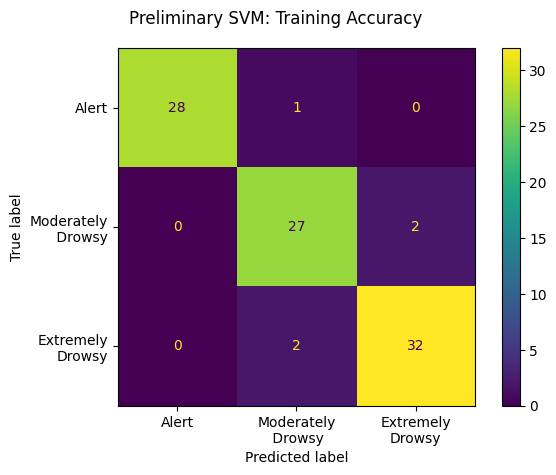

In [110]:
# Preliminary SVM: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_svm_prelim, 
                      X_train_scaled, 
                      y_train,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("Preliminary SVM: Training Accuracy")
# plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [111]:
# Training Accuracy
classwise_accuracy(clf_svm_prelim, X_train_scaled, y_train)

Accuracy of Alert: 96.5517%
Accuracy of Moderately Drowsy: 93.1034%
Accuracy of Extremely Drowsy: 94.1176%
----------------------------------------
Micro-average F1: 94.5652%
Weighted-average F1: 94.6017%
Macro-average F1: 94.6296%


* **Preliminary SVM: Testing Accuracy**

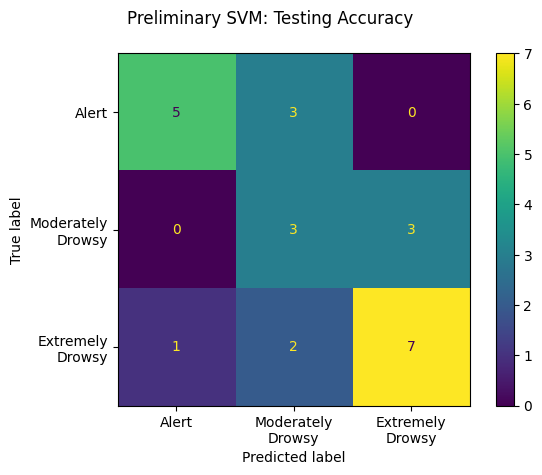

In [112]:
# Preliminary SVM: Testing Accuracy (Confusion Matrix)

ConfusionMatrix_Testing = ConfusionMatrixDisplay.from_estimator(clf_svm_prelim, 
                      X_test_scaled, 
                      y_test,  
                      display_labels=['Alert','Moderately\nDrowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Testing.figure_.suptitle("Preliminary SVM: Testing Accuracy")
plt.tight_layout()
plt.show()

In [113]:
# Testing Accuracy
classwise_accuracy(clf_svm_prelim, X_test_scaled, y_test)

Accuracy of Alert: 62.5000%
Accuracy of Moderately Drowsy: 50.0000%
Accuracy of Extremely Drowsy: 70.0000%
----------------------------------------
Micro-average F1: 62.5000%
Weighted-average F1: 63.6905%
Macro-average F1: 61.4286%


In [114]:
# Result Summary: Preliminary SVM (training)
result_summary(clf_svm_prelim, X_train, X_train_scaled, y_train)

,Original Index,Original Label,Predicted Label,True/False
2,2,1.0,1.0,True
3,3,1.0,1.0,True
4,4,1.0,1.0,True
5,5,1.0,1.0,True
6,6,1.0,1.0,True
...,...,...,...,...
113,113,3.0,3.0,True
114,114,3.0,3.0,True
115,115,3.0,3.0,True
116,116,3.0,3.0,True


In [115]:
# Result Summary: Preliminary SVM (testing)
result_summary(clf_svm_prelim, X_test, X_test_scaled, y_test)

,Original Index,Original Label,Predicted Label,True/False
0,0,1.0,2.0,False
1,1,1.0,2.0,False
12,12,1.0,1.0,True
17,17,1.0,1.0,True
32,32,1.0,1.0,True
33,33,1.0,1.0,True
36,36,1.0,2.0,False
38,38,1.0,1.0,True
43,43,2.0,2.0,True
60,60,2.0,2.0,True


##### **6.2 SVM + Optimized Parameters**

In [116]:
# Cross-Validation -> find parameters that maximize CV accuracy

param_grid = [
    {'C': [0.5, 1, 10, 100], # Regularization parameter must be > 0 #
     'gamma': ['scale', 'auto', 1, 0.1, 0.01, 0.001, 0.0001], 
     'kernel': ['rbf', 'poly']},
]

optimal_params = GridSearchCV( 
    SVC(), 
    param_grid,
    cv = 5, 
    scoring='accuracy', 
    verbose=1
)

optimal_params.fit(X_train_scaled, y_train)
print(optimal_params.best_params_)

best_cv_accuracy = optimal_params.best_score_
print(f"Best cross-validation accuracy: {best_cv_accuracy:.4f}")

Fitting 5 folds for each of 56 candidates, totalling 280 fits
{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Best cross-validation accuracy: 0.9123


In [117]:
# Building, Evaluating, Drawing, Interpreting the Final SVM

clf_svm_cv = SVC(random_state=seed, C=100, gamma=0.01, kernel='rbf')
clf_svm_cv.fit(X_train_scaled, y_train)

SVC(C=100, gamma=0.01, random_state=8)

In [227]:
with open(f'C:/Users/Natchira/Documents/M.Eng Thesis/Model/subject{subject}_SupportVectorMachine_cv.pkl', "wb") as f:
    pickle.dump(clf_svm_cv, f)

* **Optimized SVM: Training Accuracy**

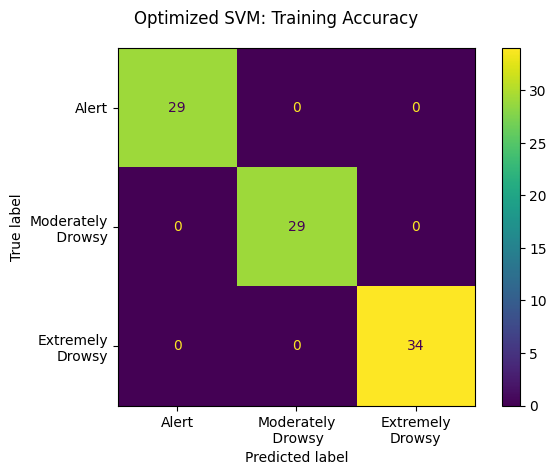

In [118]:
# Optimized SVM: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_svm_cv, 
                      X_train_scaled, 
                      y_train,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("Optimized SVM: Training Accuracy")
plt.tight_layout()
plt.show()

In [119]:
# Training Accuracy
classwise_accuracy(clf_svm_cv, X_train_scaled, y_train)

Accuracy of Alert: 100.0000%
Accuracy of Moderately Drowsy: 100.0000%
Accuracy of Extremely Drowsy: 100.0000%
----------------------------------------
Micro-average F1: 100.0000%
Weighted-average F1: 100.0000%
Macro-average F1: 100.0000%


* **Optimized SVM: Testing Accuracy**

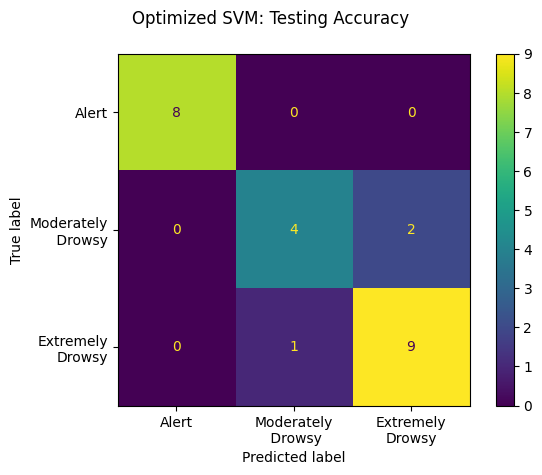

In [120]:
# Optimized SVM: Testing Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_svm_cv, 
                      X_test_scaled, 
                      y_test,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("Optimized SVM: Testing Accuracy")
plt.tight_layout()
plt.show()

In [121]:
# Testing Accuracy
classwise_accuracy(clf_svm_cv, X_test_scaled, y_test)

Accuracy of Alert: 100.0000%
Accuracy of Moderately Drowsy: 66.6667%
Accuracy of Extremely Drowsy: 90.0000%
----------------------------------------
Micro-average F1: 87.5000%
Weighted-average F1: 87.2294%
Macro-average F1: 86.1472%


In [122]:
# Result Summary: Optimized SVM (testing)
result_summary(clf_svm_cv, X_test, X_test_scaled, y_test)

,Original Index,Original Label,Predicted Label,True/False
0,0,1.0,1.0,True
1,1,1.0,1.0,True
12,12,1.0,1.0,True
17,17,1.0,1.0,True
32,32,1.0,1.0,True
33,33,1.0,1.0,True
36,36,1.0,1.0,True
38,38,1.0,1.0,True
43,43,2.0,2.0,True
60,60,2.0,2.0,True


##### **6.3 SVM with PCA**

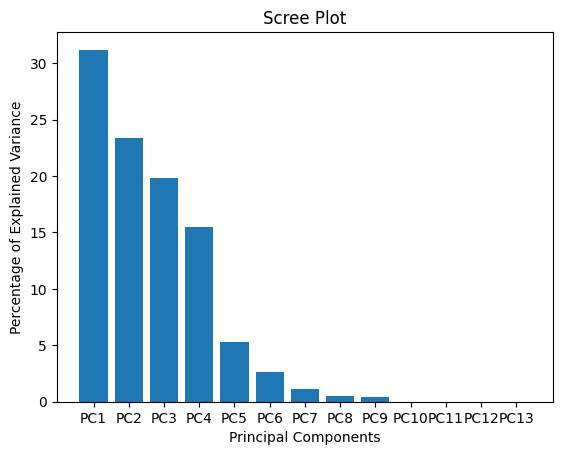

In [237]:
# PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
pca_transformer = pca.fit(X_train_scaled)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.xticks()
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree Plot')
plt.show()

In [239]:
with open(f'C:/Users/Natchira/Documents/M.Eng Thesis/Model/subject{subject}_pca_transformer.pkl', "wb") as f:
    pickle.dump(pca_transformer, f)

In [124]:
combined_features.columns

Index(['Epoch_minute', 'DeltaRelative', 'ThetaRelative', 'AlphaRelative',
       'BetaRelative', 'AlphaBetaRatio', 'TA_BRatio', 'VLF', 'LF', 'HF',
       'LFHF', 'pLF', 'pHF'],
      dtype='object')

In [125]:
# Examine the Loading Scores of Principal Components

loading_scores = pd.Series(pca.components_[0], index=combined_features.columns)
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)

top_10_features = sorted_loading_scores[0:10].index.values

print(loading_scores[top_10_features])

pLF              -0.385419
pHF               0.385419
LFHF             -0.384542
HF                0.350945
Epoch_minute     -0.316576
AlphaBetaRatio   -0.307427
TA_BRatio        -0.300970
ThetaRelative    -0.234131
AlphaRelative    -0.228981
VLF              -0.152604
dtype: float64


In [241]:
train_pc1_coords = X_train_pca[:, 0]
train_pc2_coords = X_train_pca[:, 1]
train_pc3_coords = X_train_pca[:, 2]
train_pc4_coords = X_train_pca[:, 3]
train_pc5_coords = X_train_pca[:, 4]
train_pc6_coords = X_train_pca[:, 5]
# train_pc7_coords = X_train_pca[:, 6]
# train_pc8_coords = X_train_pca[:, 7]

# NOTE:
# pc1 contains the x-axis coordinates of the data after PCA
# pc2 contains the y-axis cooridnates of the data after PCA

pca_train_scaled = scale(np.column_stack((train_pc1_coords, 
                                          train_pc2_coords, 
                                          train_pc3_coords, 
                                          train_pc4_coords, 
                                          train_pc5_coords, 
                                          train_pc6_coords, 
                                          # train_pc7_coords,
                                        #   train_pc8_coords
                                          )))

param_grid = [
    {'C': [0.5, 1, 10, 100, 1000], # Note: Values for C must be > 0
     'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001], 
     'kernel': ['rbf']},
]

optimal_params = GridSearchCV(
    SVC(), 
    param_grid,
    cv = 5, 
    scoring='accuracy', 
    verbose=0
)

optimal_params.fit(pca_train_scaled, y_train)
print(optimal_params.best_params_)

{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}


In [225]:
clf_svm_pca = SVC(random_state=seed, C=1000, gamma=0.01, kernel='rbf')
clf_svm_pca.fit(pca_train_scaled, y_train)

SVC(C=1000, gamma=0.01, random_state=8)

In [226]:
with open(f'C:/Users/Natchira/Documents/M.Eng Thesis/Model/subject{subject}_SupportVectorMachine_pca.pkl', "wb") as f:
    pickle.dump(clf_svm_pca, f)

In [ ]:
# Transform the test dataset with the PCA
# x_test_pca = pca.transform(x_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

test_pc1_coords = X_test_pca[:, 0]
test_pc2_coords = X_test_pca[:, 1]
test_pc3_coords = X_test_pca[:, 2]
test_pc4_coords = X_test_pca[:, 3]
test_pc5_coords = X_test_pca[:, 4]
test_pc6_coords = X_test_pca[:, 5]
# test_pc7_coords = X_test_pca[:, 6]
# test_pc8_coords = X_test_pca[:, 7]

pca_test_scaled = scale(np.column_stack((test_pc1_coords, 
                                         test_pc2_coords, 
                                         test_pc3_coords, 
                                         test_pc4_coords,
                                         test_pc5_coords, 
                                         test_pc6_coords, 
                                        #  test_pc7_coords,
                                        #  test_pc8_coords
                                         )))

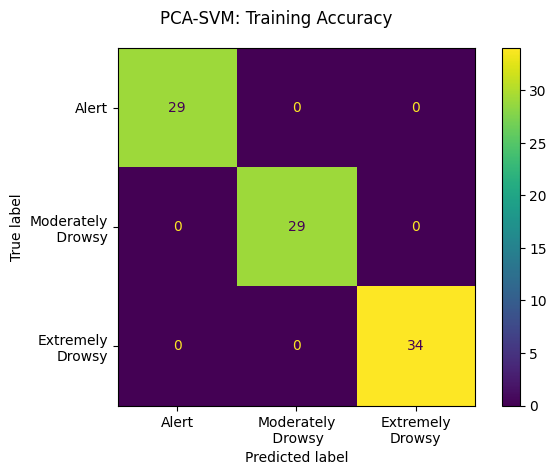

In [128]:
# PCA-SVM: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_svm_pca, 
                      pca_train_scaled, 
                      y_train,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("PCA-SVM: Training Accuracy")
plt.tight_layout()
plt.show()


In [129]:
# PCA-SVM: Training Accuracy
classwise_accuracy(clf_svm_pca, pca_train_scaled, y_train)

Accuracy of Alert: 100.0000%
Accuracy of Moderately Drowsy: 100.0000%
Accuracy of Extremely Drowsy: 100.0000%
----------------------------------------
Micro-average F1: 100.0000%
Weighted-average F1: 100.0000%
Macro-average F1: 100.0000%


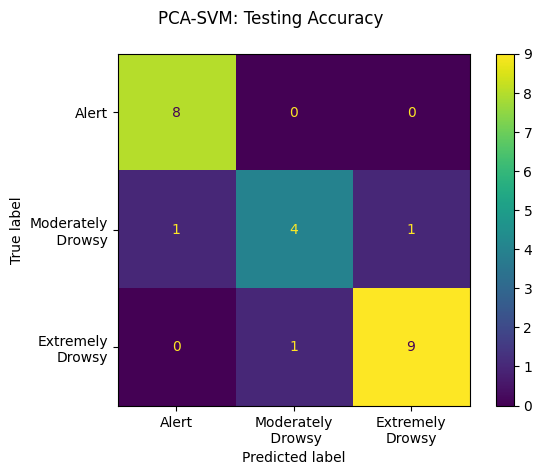

In [130]:
# PCA-SVM: Testing Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_svm_pca, 
                      pca_test_scaled, 
                      y_test,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("PCA-SVM: Testing Accuracy")
plt.tight_layout()
plt.show()


In [131]:
# PCA-SVM: Testing Accuracy
classwise_accuracy(clf_svm_pca, pca_test_scaled, y_test)

Accuracy of Alert: 100.0000%
Accuracy of Moderately Drowsy: 66.6667%
Accuracy of Extremely Drowsy: 90.0000%
----------------------------------------
Micro-average F1: 87.5000%
Weighted-average F1: 87.0544%
Macro-average F1: 85.6150%


In [132]:
# Result Summary: SVM-PCA (training)
result_summary(clf_svm_pca, X_train, pca_train_scaled, y_train)

,Original Index,Original Label,Predicted Label,True/False
2,2,1.0,1.0,True
3,3,1.0,1.0,True
4,4,1.0,1.0,True
5,5,1.0,1.0,True
6,6,1.0,1.0,True
...,...,...,...,...
113,113,3.0,3.0,True
114,114,3.0,3.0,True
115,115,3.0,3.0,True
116,116,3.0,3.0,True


In [133]:
# Result Summary: SVM-PCA (testing)
result_summary(clf_svm_pca, X_test, pca_test_scaled, y_test)

,Original Index,Original Label,Predicted Label,True/False
0,0,1.0,1.0,True
1,1,1.0,1.0,True
12,12,1.0,1.0,True
17,17,1.0,1.0,True
32,32,1.0,1.0,True
33,33,1.0,1.0,True
36,36,1.0,1.0,True
38,38,1.0,1.0,True
43,43,2.0,2.0,True
60,60,2.0,2.0,True


## **7. K-Nearest Neighbors (KNN)**

##### **7.1 K-NN (Preliminary)**

In [134]:
import math
print(math.sqrt(len(y_train)))
print(math.sqrt(len(y_test)))

9.591663046625438
4.898979485566356


In [135]:
# classifier = KNeighborsClassifier(n_neighbors=3, p=3, metric='euclidean') # odd no. for n, 
clf_knn_prelim = KNeighborsClassifier()
clf_knn_prelim.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [234]:
with open(f'C:/Users/Natchira/Documents/M.Eng Thesis/Model/subject{subject}_KNearestNeighbors_prelim.pkl', "wb") as f:
    pickle.dump(clf_knn_prelim, f)

* **Preliminary KNN: Training Accuracy**

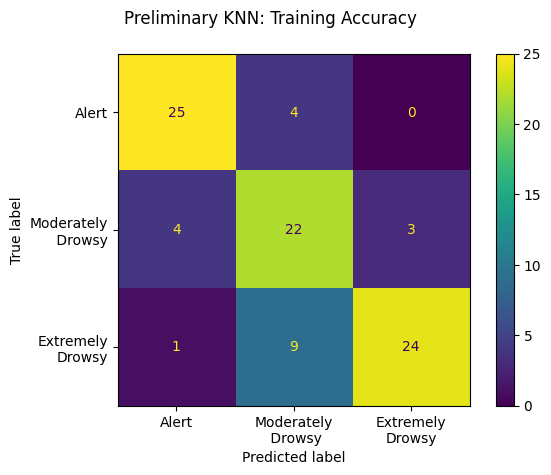

In [136]:
# Preliminary KNN: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_knn_prelim, 
                      X_train_scaled, 
                      y_train,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("Preliminary KNN: Training Accuracy")
# plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [137]:
# Training Accuracy
classwise_accuracy(clf_knn_prelim, X_train_scaled, y_train)

Accuracy of Alert: 86.2069%
Accuracy of Moderately Drowsy: 75.8621%
Accuracy of Extremely Drowsy: 70.5882%
----------------------------------------
Micro-average F1: 77.1739%
Weighted-average F1: 77.4651%
Macro-average F1: 77.3948%


* **Preliminary KNN: Testing Accuracy**

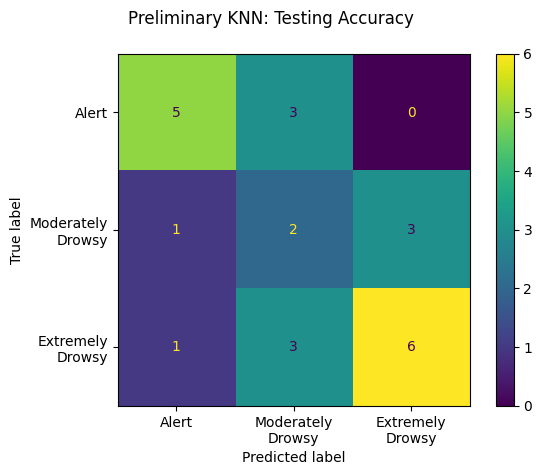

In [138]:
# Preliminary KNN: Testing Accuracy (Confusion Matrix)

ConfusionMatrix_Testing = ConfusionMatrixDisplay.from_estimator(clf_knn_prelim, 
                      X_test_scaled, 
                      y_test,  
                      display_labels=['Alert','Moderately\nDrowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Testing.figure_.suptitle("Preliminary KNN: Testing Accuracy")
plt.tight_layout()
plt.show()

In [139]:
# Testing Accuracy
classwise_accuracy(clf_knn_prelim, X_test_scaled, y_test)

Accuracy of Alert: 62.5000%
Accuracy of Moderately Drowsy: 33.3333%
Accuracy of Extremely Drowsy: 60.0000%
----------------------------------------
Micro-average F1: 54.1667%
Weighted-average F1: 55.6809%
Macro-average F1: 52.7987%


In [140]:
# Result Summary: Preliminary KNN (training)
result_summary(clf_knn_prelim, X_train, X_train_scaled, y_train)

,Original Index,Original Label,Predicted Label,True/False
2,2,1.0,2.0,False
3,3,1.0,1.0,True
4,4,1.0,1.0,True
5,5,1.0,1.0,True
6,6,1.0,1.0,True
...,...,...,...,...
113,113,3.0,3.0,True
114,114,3.0,3.0,True
115,115,3.0,3.0,True
116,116,3.0,3.0,True


In [141]:
# Result Summary: Preliminary KNN (testing)
result_summary(clf_knn_prelim, X_test, X_test_scaled, y_test)

,Original Index,Original Label,Predicted Label,True/False
0,0,1.0,2.0,False
1,1,1.0,2.0,False
12,12,1.0,1.0,True
17,17,1.0,1.0,True
32,32,1.0,1.0,True
33,33,1.0,1.0,True
36,36,1.0,2.0,False
38,38,1.0,1.0,True
43,43,2.0,2.0,True
60,60,2.0,2.0,True


##### **7.2 K-NN + Optimized Parameters**

In [142]:
knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': list(range(1,26)),
    # [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 23],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

optimal_params = GridSearchCV(
    knn, 
    param_grid, 
    cv=5, 
    scoring='accuracy', 
    verbose=1)


optimal_params.fit(X_train_scaled, y_train)

print("Best parameters:", optimal_params.best_params_)
print("Best cross-validation score:", optimal_params.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


Best parameters: {'n_neighbors': 21, 'p': 1, 'weights': 'distance'}
Best cross-validation score: 0.7836257309941521


In [143]:
# classifier = KNeighborsClassifier(n_neighbors=3, p=3, metric='euclidean') # odd no. for n, 
clf_knn_cv = KNeighborsClassifier(n_neighbors=21, p=1, weights='distance')
clf_knn_cv.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=21, p=1, weights='distance')

In [233]:
with open(f'C:/Users/Natchira/Documents/M.Eng Thesis/Model/subject{subject}_KNearestNeighbors_cv.pkl', "wb") as f:
    pickle.dump(clf_knn_cv, f)

* **Optimized KNN: Training Accuracy**

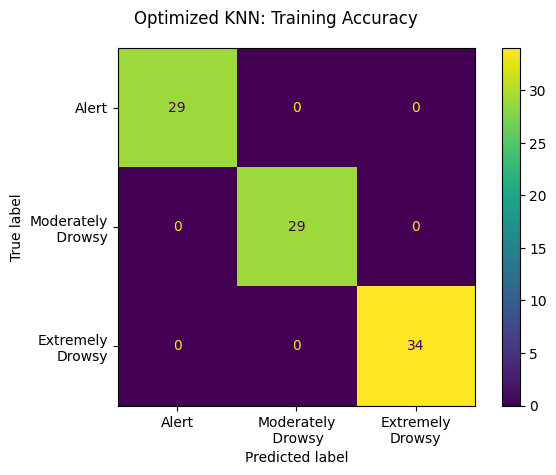

In [144]:
# Optimized KNN: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_knn_cv, 
                      X_train_scaled, 
                      y_train,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("Optimized KNN: Training Accuracy")
plt.tight_layout()
plt.show()

In [145]:
# Training Accuracy
classwise_accuracy(clf_knn_cv, X_train_scaled, y_train)

Accuracy of Alert: 100.0000%
Accuracy of Moderately Drowsy: 100.0000%
Accuracy of Extremely Drowsy: 100.0000%
----------------------------------------
Micro-average F1: 100.0000%
Weighted-average F1: 100.0000%
Macro-average F1: 100.0000%


* **Optimized KNN: Testing Accuracy**

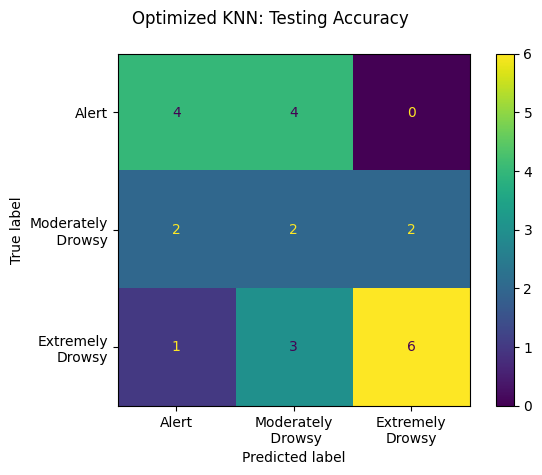

In [146]:
# Optimized KNN: Testing Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_knn_cv, 
                      X_test_scaled, 
                      y_test,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("Optimized KNN: Testing Accuracy")
plt.tight_layout()
plt.show()

In [147]:
# Testing Accuracy
classwise_accuracy(clf_knn_cv, X_test_scaled, y_test)

Accuracy of Alert: 50.0000%
Accuracy of Moderately Drowsy: 33.3333%
Accuracy of Extremely Drowsy: 60.0000%
----------------------------------------
Micro-average F1: 50.0000%
Weighted-average F1: 52.2222%
Macro-average F1: 48.8889%


In [148]:
# Result Summary: Optimized SVM (training)
result_summary(clf_knn_cv, X_train, X_train_scaled, y_train)

,Original Index,Original Label,Predicted Label,True/False
2,2,1.0,1.0,True
3,3,1.0,1.0,True
4,4,1.0,1.0,True
5,5,1.0,1.0,True
6,6,1.0,1.0,True
...,...,...,...,...
113,113,3.0,3.0,True
114,114,3.0,3.0,True
115,115,3.0,3.0,True
116,116,3.0,3.0,True


In [149]:
# Result Summary: Optimized SVM (testing)
result_summary(clf_knn_cv, X_test, X_test_scaled, y_test)

,Original Index,Original Label,Predicted Label,True/False
0,0,1.0,2.0,False
1,1,1.0,2.0,False
12,12,1.0,1.0,True
17,17,1.0,1.0,True
32,32,1.0,1.0,True
33,33,1.0,2.0,False
36,36,1.0,2.0,False
38,38,1.0,1.0,True
43,43,2.0,2.0,True
60,60,2.0,2.0,True


##### **7.3 KNN with PCA**

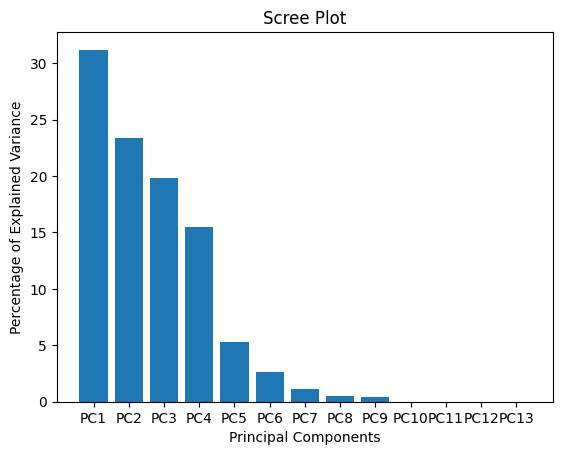

In [150]:
# PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.xticks()
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree Plot')
plt.show()

In [151]:
combined_features.columns

Index(['Epoch_minute', 'DeltaRelative', 'ThetaRelative', 'AlphaRelative',
       'BetaRelative', 'AlphaBetaRatio', 'TA_BRatio', 'VLF', 'LF', 'HF',
       'LFHF', 'pLF', 'pHF'],
      dtype='object')

In [152]:
# Examine the Loading Scores of Principal Components

loading_scores = pd.Series(pca.components_[0], index=combined_features.columns)
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)

top_10_features = sorted_loading_scores[0:10].index.values

print(loading_scores[top_10_features])

pLF              -0.385419
pHF               0.385419
LFHF             -0.384542
HF                0.350945
Epoch_minute     -0.316576
AlphaBetaRatio   -0.307427
TA_BRatio        -0.300970
ThetaRelative    -0.234131
AlphaRelative    -0.228981
VLF              -0.152604
dtype: float64


In [153]:
train_pc1_coords = X_train_pca[:, 0]
train_pc2_coords = X_train_pca[:, 1]
train_pc3_coords = X_train_pca[:, 2]
train_pc4_coords = X_train_pca[:, 3]
train_pc5_coords = X_train_pca[:, 4]
train_pc6_coords = X_train_pca[:, 5]
# train_pc7_coords = X_train_pca[:, 6]
# train_pc8_coords = X_train_pca[:, 7]

# NOTE:
# pc1 contains the x-axis coordinates of the data after PCA
# pc2 contains the y-axis cooridnates of the data after PCA

pca_train_scaled = scale(np.column_stack((train_pc1_coords, 
                                          train_pc2_coords, 
                                          train_pc3_coords, 
                                          train_pc4_coords, 
                                          train_pc5_coords, 
                                          train_pc6_coords, 
                                          # train_pc7_coords,
                                        #   train_pc8_coords
                                          )))


In [154]:
param_grid = {
    'n_neighbors': list(range(1,26)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

optimal_params = GridSearchCV(
    KNeighborsClassifier(), 
    param_grid, 
    cv=5, 
    scoring='accuracy', 
    verbose=1)


optimal_params.fit(pca_train_scaled, y_train)

print("Best parameters:", optimal_params.best_params_)
print("Best cross-validation score:", optimal_params.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


Best parameters: {'n_neighbors': 21, 'p': 2, 'weights': 'distance'}
Best cross-validation score: 0.8046783625730995


In [155]:
clf_knn_pca = KNeighborsClassifier(n_neighbors=21, p=2, weights='distance')
clf_knn_pca.fit(pca_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=21, weights='distance')

In [232]:
with open(f'C:/Users/Natchira/Documents/M.Eng Thesis/Model/subject{subject}_KNearestNeighbors_pca.pkl', "wb") as f:
    pickle.dump(clf_knn_pca, f)

In [156]:
# Transform the test dataset with the PCA
# x_test_pca = pca.transform(x_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

test_pc1_coords = X_test_pca[:, 0]
test_pc2_coords = X_test_pca[:, 1]
test_pc3_coords = X_test_pca[:, 2]
test_pc4_coords = X_test_pca[:, 3]
test_pc5_coords = X_test_pca[:, 4]
test_pc6_coords = X_test_pca[:, 5]
# test_pc7_coords = X_test_pca[:, 6]
# test_pc8_coords = X_test_pca[:, 7]

pca_test_scaled = scale(np.column_stack((test_pc1_coords, 
                                         test_pc2_coords, 
                                         test_pc3_coords, 
                                         test_pc4_coords,
                                         test_pc5_coords, 
                                         test_pc6_coords, 
                                        #  test_pc7_coords,
                                        #  test_pc8_coords
                                         )))

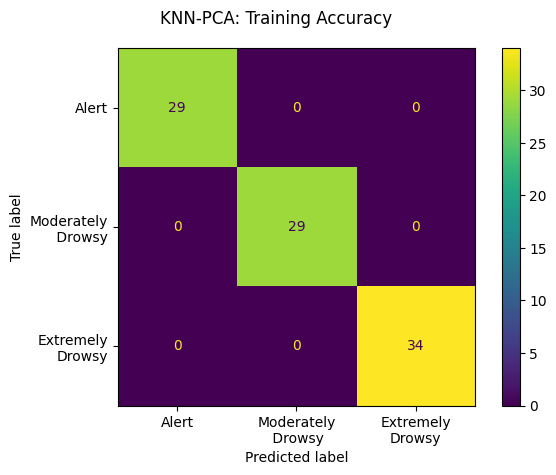

In [157]:
# PCA-KNN: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_knn_pca, 
                      pca_train_scaled, 
                      y_train,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("KNN-PCA: Training Accuracy")
plt.tight_layout()
plt.show()


In [158]:
# PCA-SVM: Training Accuracy
classwise_accuracy(clf_knn_pca, pca_train_scaled, y_train)

Accuracy of Alert: 100.0000%
Accuracy of Moderately Drowsy: 100.0000%
Accuracy of Extremely Drowsy: 100.0000%
----------------------------------------
Micro-average F1: 100.0000%
Weighted-average F1: 100.0000%
Macro-average F1: 100.0000%


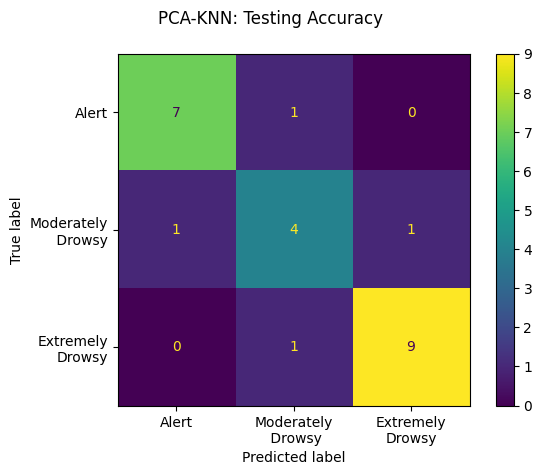

In [159]:
# PCA-KNN: Testing Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_knn_pca, 
                      pca_test_scaled, 
                      y_test,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("PCA-KNN: Testing Accuracy")
plt.tight_layout()
plt.show()


In [160]:
# PCA-KNN: Testing Accuracy
classwise_accuracy(clf_knn_pca, pca_test_scaled, y_test)

Accuracy of Alert: 87.5000%
Accuracy of Moderately Drowsy: 66.6667%
Accuracy of Extremely Drowsy: 90.0000%
----------------------------------------
Micro-average F1: 83.3333%
Weighted-average F1: 83.3333%
Macro-average F1: 81.3889%


In [161]:
# Result Summary: KNN-PCA (training)
result_summary(clf_knn_pca, X_train, pca_train_scaled, y_train)

,Original Index,Original Label,Predicted Label,True/False
2,2,1.0,1.0,True
3,3,1.0,1.0,True
4,4,1.0,1.0,True
5,5,1.0,1.0,True
6,6,1.0,1.0,True
...,...,...,...,...
113,113,3.0,3.0,True
114,114,3.0,3.0,True
115,115,3.0,3.0,True
116,116,3.0,3.0,True


## **8. Decision Tree** 

##### **8.1 Decision Tree (Preliminary)**

In [162]:
clf_dt_prelim = DecisionTreeClassifier()
clf_dt_prelim.fit(X_train_scaled, y_train)

DecisionTreeClassifier()

In [221]:
with open(f'C:/Users/Natchira/Documents/M.Eng Thesis/Model/subject{subject}_DecisionTree_prelim.pkl', "wb") as f:
    pickle.dump(clf_dt_prelim, f)

* **Preliminary DT: Training Accuracy**

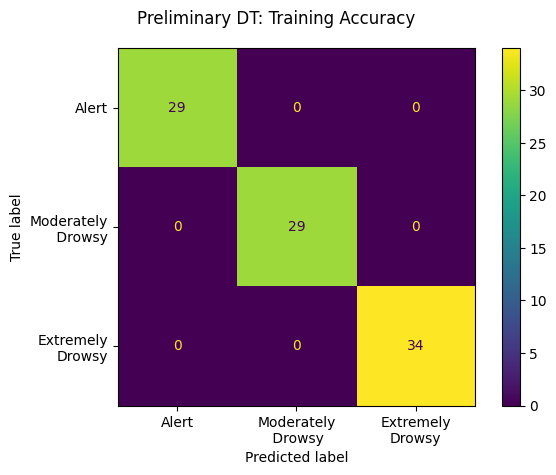

In [163]:
# Preliminary KNN: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_dt_prelim, 
                      X_train_scaled, 
                      y_train,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("Preliminary DT: Training Accuracy")
# plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [164]:
# Training Accuracy
classwise_accuracy(clf_dt_prelim, X_train_scaled, y_train)

Accuracy of Alert: 100.0000%
Accuracy of Moderately Drowsy: 100.0000%
Accuracy of Extremely Drowsy: 100.0000%
----------------------------------------
Micro-average F1: 100.0000%
Weighted-average F1: 100.0000%
Macro-average F1: 100.0000%


* **Preliminary DT: Testing Accuracy**

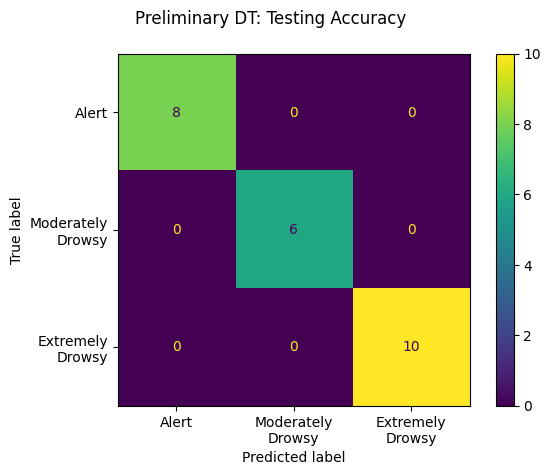

In [165]:
# Preliminary DT: Testing Accuracy (Confusion Matrix)

ConfusionMatrix_Testing = ConfusionMatrixDisplay.from_estimator(clf_dt_prelim, 
                      X_test_scaled, 
                      y_test,  
                      display_labels=['Alert','Moderately\nDrowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Testing.figure_.suptitle("Preliminary DT: Testing Accuracy")
plt.tight_layout()
plt.show()

In [166]:
# Testing Accuracy
classwise_accuracy(clf_dt_prelim, X_test_scaled, y_test)

Accuracy of Alert: 100.0000%
Accuracy of Moderately Drowsy: 100.0000%
Accuracy of Extremely Drowsy: 100.0000%
----------------------------------------
Micro-average F1: 100.0000%
Weighted-average F1: 100.0000%
Macro-average F1: 100.0000%


##### **8.2 Decision Tree + Optimized Parameters**

In [167]:
classifier = DecisionTreeClassifier()

param_grid = {
    'max_depth': range(2, 21),  # Explore depths from 2 to 20
    'min_samples_split': range(2, 11),  # Minimum samples for a split (2 to 10)
    'min_samples_leaf': range(1, 6),   # Minimum samples required at each leaf (1 to 5)
    'criterion': ['gini', 'entropy']  # Splitting criteria (gini or entropy)
}

optimal_params = GridSearchCV(
    classifier, 
    param_grid, 
    cv=5, 
    scoring='accuracy', 
    verbose=1)


optimal_params.fit(X_train_scaled, y_train)

print("Best parameters:", optimal_params.best_params_)
print("Best cross-validation score:", optimal_params.best_score_)

Fitting 5 folds for each of 1710 candidates, totalling 8550 fits


Best parameters: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best cross-validation score: 0.9567251461988304


In [168]:
clf_dt_cv = DecisionTreeClassifier(criterion = 'gini', max_depth = 2, min_samples_leaf = 1, min_samples_split = 2)
clf_dt_cv.fit(X_train_scaled, y_train)

DecisionTreeClassifier(max_depth=2)

In [220]:
with open(f'C:/Users/Natchira/Documents/M.Eng Thesis/Model/subject{subject}_DecisionTree_cv.pkl', "wb") as f:
    pickle.dump(clf_dt_cv, f)

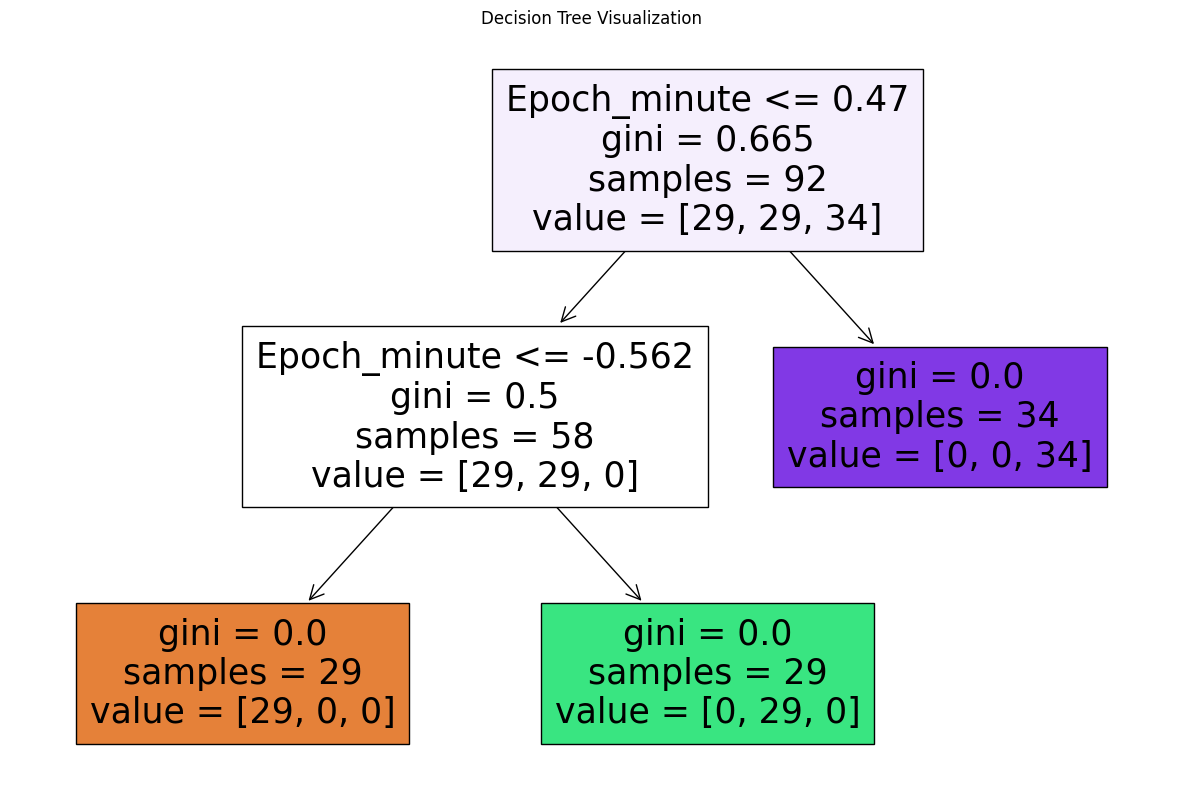

In [169]:
fig, ax = plt.subplots(figsize=(15, 10))
plot_tree(clf_dt_cv, ax = ax, feature_names = combined_features.columns, filled = True)
plt.title("Decision Tree Visualization")
plt.show()

* **Optimized DT: Training Accuracy**

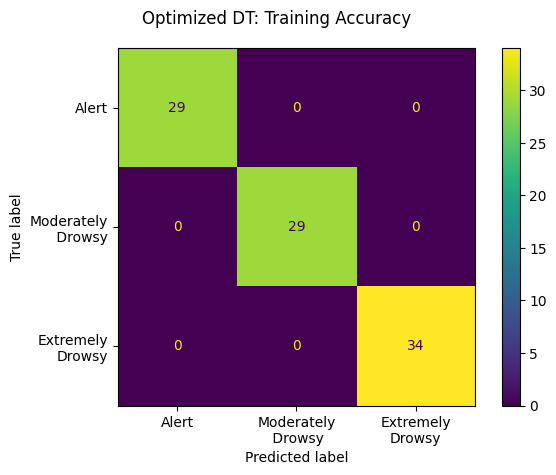

In [170]:
# Optimized KNN: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_dt_cv, 
                      X_train_scaled, 
                      y_train,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("Optimized DT: Training Accuracy")
plt.tight_layout()
plt.show()

In [171]:
# Training Accuracy
classwise_accuracy(clf_dt_cv, X_train_scaled, y_train)

Accuracy of Alert: 100.0000%
Accuracy of Moderately Drowsy: 100.0000%
Accuracy of Extremely Drowsy: 100.0000%
----------------------------------------
Micro-average F1: 100.0000%
Weighted-average F1: 100.0000%
Macro-average F1: 100.0000%


* **Optimized DT: Testing Accuracy**

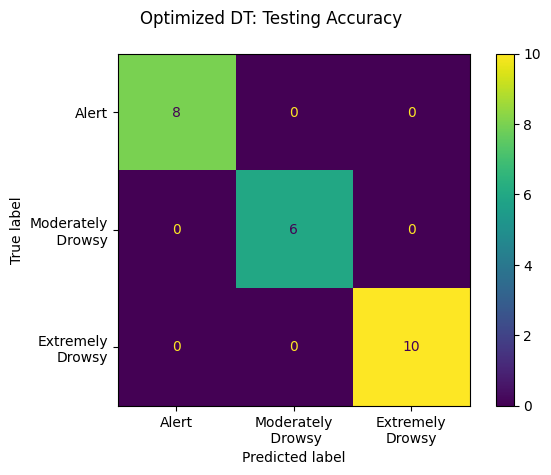

In [172]:
# Optimized DT: Testing Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_dt_cv, 
                      X_test_scaled, 
                      y_test,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("Optimized DT: Testing Accuracy")
plt.tight_layout()
plt.show()

In [173]:
# Testing Accuracy
classwise_accuracy(clf_dt_cv, X_test_scaled, y_test)

Accuracy of Alert: 100.0000%
Accuracy of Moderately Drowsy: 100.0000%
Accuracy of Extremely Drowsy: 100.0000%
----------------------------------------
Micro-average F1: 100.0000%
Weighted-average F1: 100.0000%
Macro-average F1: 100.0000%


In [174]:
# Result Summary: Optimized SVM (training)
result_summary(clf_dt_cv, X_train, X_train_scaled, y_train)

,Original Index,Original Label,Predicted Label,True/False
2,2,1.0,1.0,True
3,3,1.0,1.0,True
4,4,1.0,1.0,True
5,5,1.0,1.0,True
6,6,1.0,1.0,True
...,...,...,...,...
113,113,3.0,3.0,True
114,114,3.0,3.0,True
115,115,3.0,3.0,True
116,116,3.0,3.0,True


In [175]:
# Result Summary: Optimized SVM (testing)
result_summary(clf_dt_cv, X_test, X_test_scaled, y_test)

,Original Index,Original Label,Predicted Label,True/False
0,0,1.0,1.0,True
1,1,1.0,1.0,True
12,12,1.0,1.0,True
17,17,1.0,1.0,True
32,32,1.0,1.0,True
33,33,1.0,1.0,True
36,36,1.0,1.0,True
38,38,1.0,1.0,True
43,43,2.0,2.0,True
60,60,2.0,2.0,True


##### **8.3 Decision Tree with PCA**

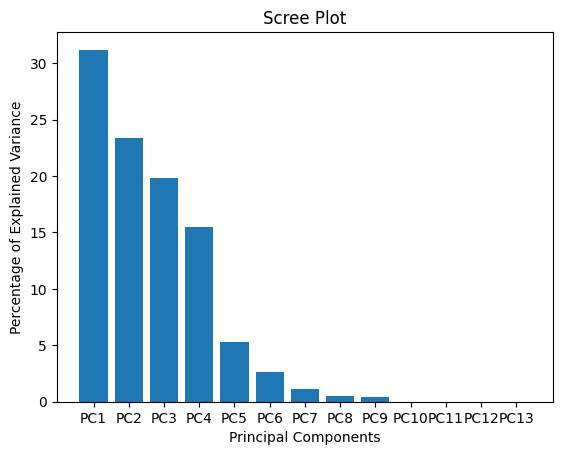

In [176]:
# PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.xticks()
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree Plot')
plt.show()

In [177]:
combined_features.columns

Index(['Epoch_minute', 'DeltaRelative', 'ThetaRelative', 'AlphaRelative',
       'BetaRelative', 'AlphaBetaRatio', 'TA_BRatio', 'VLF', 'LF', 'HF',
       'LFHF', 'pLF', 'pHF'],
      dtype='object')

In [178]:
# Examine the Loading Scores of Principal Components

loading_scores = pd.Series(pca.components_[0], index=combined_features.columns)
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)

top_10_features = sorted_loading_scores[0:10].index.values

print(loading_scores[top_10_features])

pLF              -0.385419
pHF               0.385419
LFHF             -0.384542
HF                0.350945
Epoch_minute     -0.316576
AlphaBetaRatio   -0.307427
TA_BRatio        -0.300970
ThetaRelative    -0.234131
AlphaRelative    -0.228981
VLF              -0.152604
dtype: float64


In [179]:
train_pc1_coords = X_train_pca[:, 0]
train_pc2_coords = X_train_pca[:, 1]
train_pc3_coords = X_train_pca[:, 2]
train_pc4_coords = X_train_pca[:, 3]
train_pc5_coords = X_train_pca[:, 4]
train_pc6_coords = X_train_pca[:, 5]
# train_pc7_coords = X_train_pca[:, 6]
# train_pc8_coords = X_train_pca[:, 7]

# NOTE:
# pc1 contains the x-axis coordinates of the data after PCA
# pc2 contains the y-axis cooridnates of the data after PCA

pca_train_scaled = scale(np.column_stack((train_pc1_coords, 
                                          train_pc2_coords, 
                                          train_pc3_coords, 
                                          train_pc4_coords, 
                                          train_pc5_coords, 
                                          train_pc6_coords, 
                                          # train_pc7_coords,
                                        #   train_pc8_coords
                                          )))


In [180]:
classifier = DecisionTreeClassifier()

param_grid = {
    'max_depth': range(2, 21),  # Explore depths from 2 to 20
    'min_samples_split': range(2, 11),  # Minimum samples for a split (2 to 10)
    'min_samples_leaf': range(1, 6),   # Minimum samples required at each leaf (1 to 5)
    'criterion': ['gini', 'entropy']  # Splitting criteria (gini or entropy)
}

optimal_params = GridSearchCV(
    classifier, 
    param_grid, 
    cv=5, 
    scoring='accuracy', 
    verbose=1)


optimal_params.fit(pca_train_scaled, y_train)

print("Best parameters:", optimal_params.best_params_)
print("Best cross-validation score:", optimal_params.best_score_)

Fitting 5 folds for each of 1710 candidates, totalling 8550 fits


Best parameters: {'criterion': 'gini', 'max_depth': 18, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best cross-validation score: 0.7070175438596491


In [181]:
clf_dt_pca = DecisionTreeClassifier(criterion = 'gini', max_depth = 9, min_samples_leaf = 1, min_samples_split = 2)
clf_dt_pca.fit(pca_train_scaled, y_train)

DecisionTreeClassifier(max_depth=9)

In [182]:
with open(f'C:/Users/Natchira/Documents/M.Eng Thesis/Model/subject{subject}_DecisionTree_pca.pkl', "wb") as f:
    pickle.dump(clf_dt_pca, f)

In [183]:
# Transform the test dataset with the PCA
# x_test_pca = pca.transform(x_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

test_pc1_coords = X_test_pca[:, 0]
test_pc2_coords = X_test_pca[:, 1]
test_pc3_coords = X_test_pca[:, 2]
test_pc4_coords = X_test_pca[:, 3]
test_pc5_coords = X_test_pca[:, 4]
test_pc6_coords = X_test_pca[:, 5]
# test_pc7_coords = X_test_pca[:, 6]
# test_pc8_coords = X_test_pca[:, 7]

pca_test_scaled = scale(np.column_stack((test_pc1_coords, 
                                         test_pc2_coords, 
                                         test_pc3_coords, 
                                         test_pc4_coords,
                                         test_pc5_coords, 
                                         test_pc6_coords, 
                                        #  test_pc7_coords,
                                        #  test_pc8_coords
                                         )))

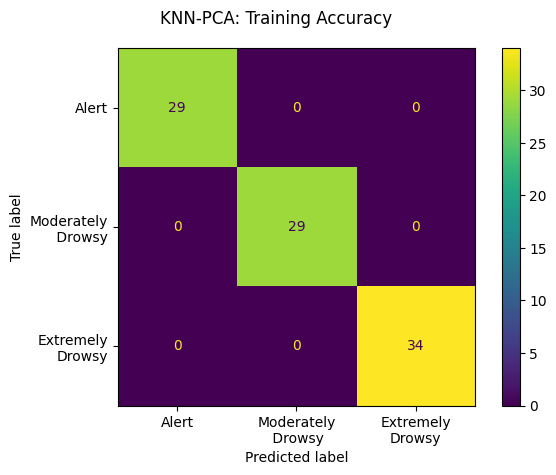

In [184]:
# PCA-KNN: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_dt_pca, 
                      pca_train_scaled, 
                      y_train,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("KNN-PCA: Training Accuracy")
plt.tight_layout()
plt.show()


In [185]:
# PCA-SVM: Training Accuracy
classwise_accuracy(clf_dt_pca, pca_train_scaled, y_train)

Accuracy of Alert: 100.0000%
Accuracy of Moderately Drowsy: 100.0000%
Accuracy of Extremely Drowsy: 100.0000%
----------------------------------------
Micro-average F1: 100.0000%
Weighted-average F1: 100.0000%
Macro-average F1: 100.0000%


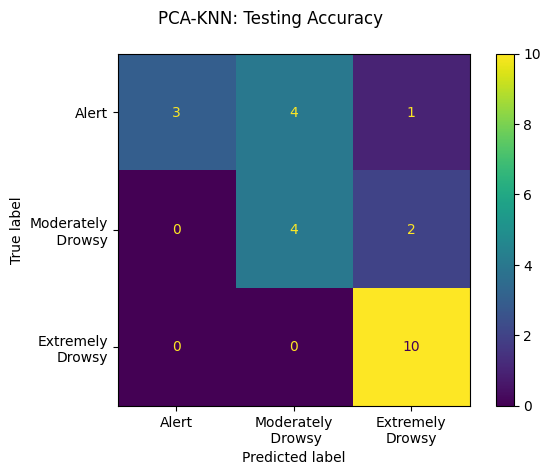

In [186]:
# PCA-KNN: Testing Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_dt_pca, 
                      pca_test_scaled, 
                      y_test,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("PCA-KNN: Testing Accuracy")
plt.tight_layout()
plt.show()


In [187]:
# PCA-KNN: Testing Accuracy
classwise_accuracy(clf_dt_pca, pca_test_scaled, y_test)

Accuracy of Alert: 37.5000%
Accuracy of Moderately Drowsy: 66.6667%
Accuracy of Extremely Drowsy: 100.0000%
----------------------------------------
Micro-average F1: 70.8333%
Weighted-average F1: 68.6994%
Macro-average F1: 66.2149%


In [188]:
# Result Summary: KNN-PCA (training)
result_summary(clf_dt_pca, X_train, pca_train_scaled, y_train)

,Original Index,Original Label,Predicted Label,True/False
2,2,1.0,1.0,True
3,3,1.0,1.0,True
4,4,1.0,1.0,True
5,5,1.0,1.0,True
6,6,1.0,1.0,True
...,...,...,...,...
113,113,3.0,3.0,True
114,114,3.0,3.0,True
115,115,3.0,3.0,True
116,116,3.0,3.0,True


## **9. Random Forest**

##### **9.1 Random Forest (Preliminary)**

In [189]:
clf_rf_prelim = RandomForestClassifier()
clf_rf_prelim.fit(X_train_scaled, y_train)

RandomForestClassifier()

In [190]:
with open(f'C:/Users/Natchira/Documents/M.Eng Thesis/Model/subject{subject}_RandomForest_prelim.pkl', "wb") as f:
    pickle.dump(clf_rf_prelim, f)

* **Preliminary RF: Training Accuracy**

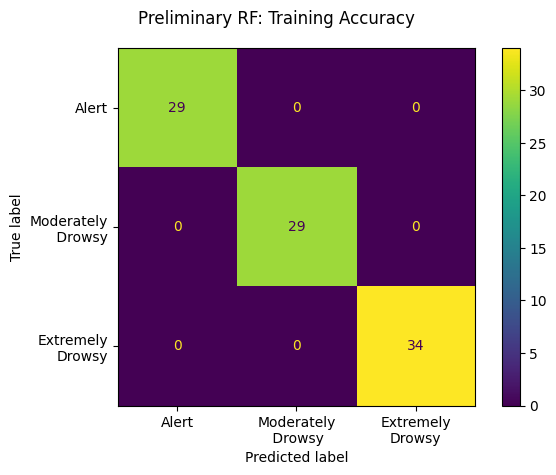

In [191]:
# Preliminary RF: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_rf_prelim, 
                      X_train_scaled, 
                      y_train,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("Preliminary RF: Training Accuracy")
# plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [192]:
# Training Accuracy
classwise_accuracy(clf_rf_prelim, X_train_scaled, y_train)

Accuracy of Alert: 100.0000%
Accuracy of Moderately Drowsy: 100.0000%
Accuracy of Extremely Drowsy: 100.0000%
----------------------------------------
Micro-average F1: 100.0000%
Weighted-average F1: 100.0000%
Macro-average F1: 100.0000%


* **Preliminary RF: Testing Accuracy**

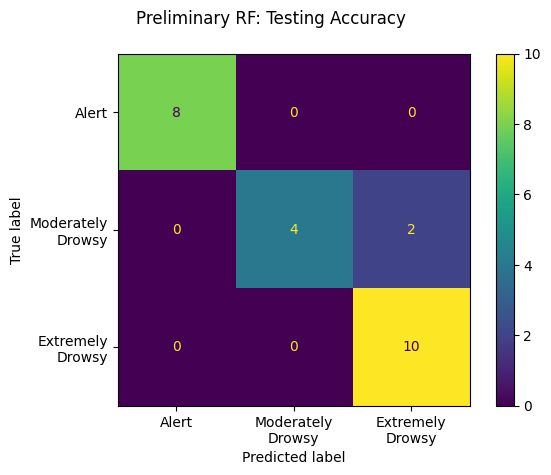

In [193]:
# Preliminary RF: Testing Accuracy (Confusion Matrix)

ConfusionMatrix_Testing = ConfusionMatrixDisplay.from_estimator(clf_rf_prelim, 
                      X_test_scaled, 
                      y_test,  
                      display_labels=['Alert','Moderately\nDrowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Testing.figure_.suptitle("Preliminary RF: Testing Accuracy")
plt.tight_layout()
plt.show()

In [194]:
# Testing Accuracy
classwise_accuracy(clf_rf_prelim, X_test_scaled, y_test)

Accuracy of Alert: 100.0000%
Accuracy of Moderately Drowsy: 66.6667%
Accuracy of Extremely Drowsy: 100.0000%
----------------------------------------
Micro-average F1: 91.6667%
Weighted-average F1: 91.2121%
Macro-average F1: 90.3030%


In [195]:
# Result Summary: Preliminary RF (training)
result_summary(clf_rf_prelim, X_train, X_train_scaled, y_train)

,Original Index,Original Label,Predicted Label,True/False
2,2,1.0,1.0,True
3,3,1.0,1.0,True
4,4,1.0,1.0,True
5,5,1.0,1.0,True
6,6,1.0,1.0,True
...,...,...,...,...
113,113,3.0,3.0,True
114,114,3.0,3.0,True
115,115,3.0,3.0,True
116,116,3.0,3.0,True


In [196]:
# Result Summary: Preliminary rf (testing)
result_summary(clf_rf_prelim, X_test, X_test_scaled, y_test)

,Original Index,Original Label,Predicted Label,True/False
0,0,1.0,1.0,True
1,1,1.0,1.0,True
12,12,1.0,1.0,True
17,17,1.0,1.0,True
32,32,1.0,1.0,True
33,33,1.0,1.0,True
36,36,1.0,1.0,True
38,38,1.0,1.0,True
43,43,2.0,2.0,True
60,60,2.0,2.0,True


##### **9.2 Random Forest + Optimized Parameters**

In [197]:
param_grid = {
  'n_estimators': [100],  # Number of trees in the forest
  'max_depth': range(2, 5),  # Explore depths from 2 to 20
  'min_samples_split': range(2, 5),  # Minimum samples for a split (2 to 10)
  'min_samples_leaf': range(1, 6),   # Minimum samples required at each leaf (1 to 5)
  'max_features': ['sqrt', 'log2']  # Number of features to consider at each split
}

# Create a RandomForestClassifier object
clf = RandomForestClassifier()

# Use GridSearchCV for hyperparameter tuning
optimal_params = GridSearchCV(
    clf,  # Use RandomForestClassifier here
    param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',  # Use accuracy as scoring metric
    verbose=1,  # Print progress during search
    # estimator=tqdm(clf)
)

optimal_params.fit(X_train_scaled, y_train)

print("Best parameters:", optimal_params.best_params_)
print("Best cross-validation score:", optimal_params.best_score_)


Fitting 5 folds for each of 90 candidates, totalling 450 fits


Best parameters: {'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 100}
Best cross-validation score: 0.956140350877193


In [198]:
# classifier = KNeighborsClassifier(n_neighbors=3, p=3, metric='euclidean') # odd no. for n, 
clf_rf_cv = RandomForestClassifier(max_depth=4, max_features='sqrt', min_samples_leaf=2, min_samples_split=3, n_estimators=100)
clf_rf_cv.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=4, min_samples_leaf=2, min_samples_split=3)

In [199]:
with open(f'C:/Users/Natchira/Documents/M.Eng Thesis/Model/subject{subject}_RandomForest_cv.pkl', "wb") as f:
    pickle.dump(clf_rf_cv, f)

* **Optimized RF: Training Accuracy**

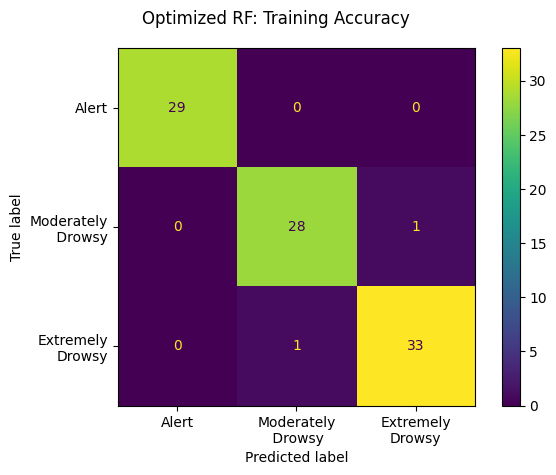

In [200]:
# Optimized RF: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_rf_cv, 
                      X_train_scaled, 
                      y_train,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("Optimized RF: Training Accuracy")
plt.tight_layout()
plt.show()

In [201]:
# Training Accuracy
classwise_accuracy(clf_rf_cv, X_train_scaled, y_train)

Accuracy of Alert: 100.0000%
Accuracy of Moderately Drowsy: 96.5517%
Accuracy of Extremely Drowsy: 97.0588%
----------------------------------------
Micro-average F1: 97.8261%
Weighted-average F1: 97.8261%
Macro-average F1: 97.8702%


* **Optimized RF: Testing Accuracy**

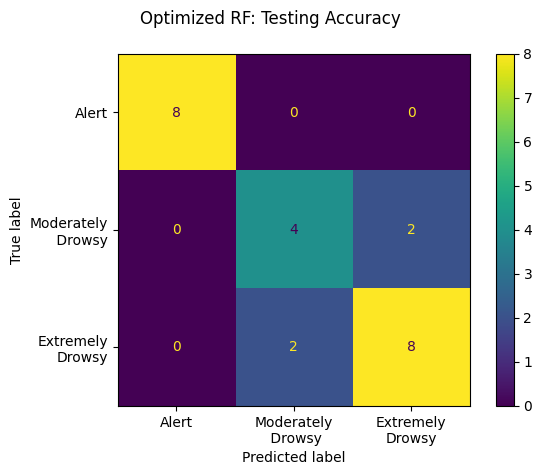

In [202]:
# Optimized KNN: Testing Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_rf_cv, 
                      X_test_scaled, 
                      y_test,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("Optimized RF: Testing Accuracy")
plt.tight_layout()
plt.show()

In [203]:
# Testing Accuracy
classwise_accuracy(clf_rf_cv, X_test_scaled, y_test)

Accuracy of Alert: 100.0000%
Accuracy of Moderately Drowsy: 66.6667%
Accuracy of Extremely Drowsy: 80.0000%
----------------------------------------
Micro-average F1: 83.3333%
Weighted-average F1: 83.3333%
Macro-average F1: 82.2222%


In [204]:
# Result Summary: Optimized SVM (training)
result_summary(clf_rf_cv, X_train, X_train_scaled, y_train)

,Original Index,Original Label,Predicted Label,True/False
2,2,1.0,1.0,True
3,3,1.0,1.0,True
4,4,1.0,1.0,True
5,5,1.0,1.0,True
6,6,1.0,1.0,True
...,...,...,...,...
113,113,3.0,3.0,True
114,114,3.0,3.0,True
115,115,3.0,3.0,True
116,116,3.0,3.0,True


In [205]:
# Result Summary: Optimized SVM (testing)
result_summary(clf_rf_cv, X_test, X_test_scaled, y_test)

,Original Index,Original Label,Predicted Label,True/False
0,0,1.0,1.0,True
1,1,1.0,1.0,True
12,12,1.0,1.0,True
17,17,1.0,1.0,True
32,32,1.0,1.0,True
33,33,1.0,1.0,True
36,36,1.0,1.0,True
38,38,1.0,1.0,True
43,43,2.0,2.0,True
60,60,2.0,2.0,True


##### **9.3 Random Forest with PCA**

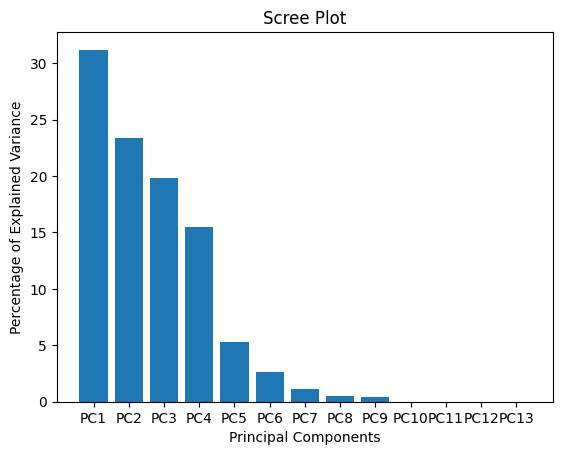

In [206]:
# PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.xticks()
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree Plot')
plt.show()

In [207]:
combined_features.columns

Index(['Epoch_minute', 'DeltaRelative', 'ThetaRelative', 'AlphaRelative',
       'BetaRelative', 'AlphaBetaRatio', 'TA_BRatio', 'VLF', 'LF', 'HF',
       'LFHF', 'pLF', 'pHF'],
      dtype='object')

In [208]:
# Examine the Loading Scores of Principal Components

loading_scores = pd.Series(pca.components_[0], index=combined_features.columns)
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)

top_10_features = sorted_loading_scores[0:10].index.values

print(loading_scores[top_10_features])

pLF              -0.385419
pHF               0.385419
LFHF             -0.384542
HF                0.350945
Epoch_minute     -0.316576
AlphaBetaRatio   -0.307427
TA_BRatio        -0.300970
ThetaRelative    -0.234131
AlphaRelative    -0.228981
VLF              -0.152604
dtype: float64


In [209]:
train_pc1_coords = X_train_pca[:, 0]
train_pc2_coords = X_train_pca[:, 1]
train_pc3_coords = X_train_pca[:, 2]
train_pc4_coords = X_train_pca[:, 3]
train_pc5_coords = X_train_pca[:, 4]
train_pc6_coords = X_train_pca[:, 5]
# train_pc7_coords = X_train_pca[:, 6]
# train_pc8_coords = X_train_pca[:, 7]

# NOTE:
# pc1 contains the x-axis coordinates of the data after PCA
# pc2 contains the y-axis cooridnates of the data after PCA

pca_train_scaled = scale(np.column_stack((train_pc1_coords, 
                                          train_pc2_coords, 
                                          train_pc3_coords, 
                                          train_pc4_coords, 
                                          train_pc5_coords, 
                                          train_pc6_coords, 
                                          # train_pc7_coords,
                                        #   train_pc8_coords
                                          )))

In [210]:
# param_grid = {
#   'n_estimators': [100, 200, 300],  # Number of trees in the forest
#   'max_depth': range(2, 21),  # Explore depths from 2 to 20
#   'min_samples_split': range(2, 11),  # Minimum samples for a split (2 to 10)
#   'min_samples_leaf': range(1, 6),   # Minimum samples required at each leaf (1 to 5)
#   'max_features': ['sqrt', 'log2']  # Number of features to consider at each split
# }

# # Create a RandomForestClassifier object
# clf = RandomForestClassifier()

# # Use GridSearchCV for hyperparameter tuning
# optimal_params = GridSearchCV(
#     clf,  # Use RandomForestClassifier here
#     param_grid,
#     cv=5,  # 5-fold cross-validation
#     scoring='accuracy',  # Use accuracy as scoring metric
#     verbose=1,  # Print progress during search

# )

# optimal_params.fit(pca_train_scaled, y_train)

# print("Best parameters:", optimal_params.best_params_)
# print("Best cross-validation score:", optimal_params.best_score_)

Fitting 5 folds for each of 5130 candidates, totalling 25650 fits


KeyboardInterrupt: 

In [211]:
clf_rf_pca = RandomForestClassifier(max_depth=4, max_features='sqrt', min_samples_leaf=2, min_samples_split=3, n_estimators=100)
clf_rf_pca.fit(pca_train_scaled, y_train)

RandomForestClassifier(max_depth=4, min_samples_leaf=2, min_samples_split=3)

In [212]:
with open(f'C:/Users/Natchira/Documents/M.Eng Thesis/Model/subject{subject}_RandomForest_pca.pkl', "wb") as f:
    pickle.dump(clf_rf_pca, f)

In [213]:
# Transform the test dataset with the PCA
# x_test_pca = pca.transform(x_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

test_pc1_coords = X_test_pca[:, 0]
test_pc2_coords = X_test_pca[:, 1]
test_pc3_coords = X_test_pca[:, 2]
test_pc4_coords = X_test_pca[:, 3]
test_pc5_coords = X_test_pca[:, 4]
test_pc6_coords = X_test_pca[:, 5]
# test_pc7_coords = X_test_pca[:, 6]
# test_pc8_coords = X_test_pca[:, 7]

pca_test_scaled = scale(np.column_stack((test_pc1_coords, 
                                         test_pc2_coords, 
                                         test_pc3_coords, 
                                         test_pc4_coords,
                                         test_pc5_coords, 
                                         test_pc6_coords, 
                                        #  test_pc7_coords,
                                        #  test_pc8_coords
                                         )))

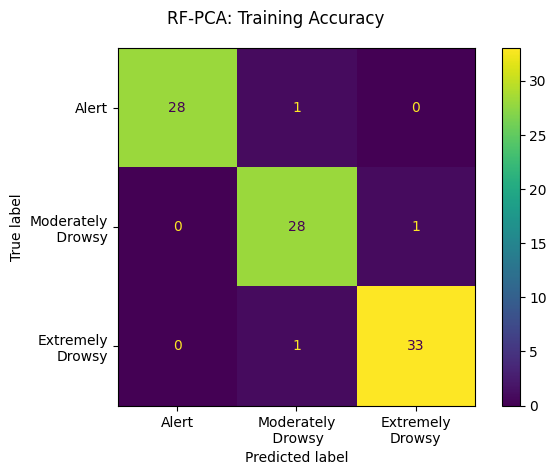

In [214]:
# PCA-RF: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_rf_pca, 
                      pca_train_scaled, 
                      y_train,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("RF-PCA: Training Accuracy")
plt.tight_layout()
plt.show()


In [215]:
# PCA-RF: Training Accuracy
classwise_accuracy(clf_rf_pca, pca_train_scaled, y_train)

Accuracy of Alert: 96.5517%
Accuracy of Moderately Drowsy: 96.5517%
Accuracy of Extremely Drowsy: 97.0588%
----------------------------------------
Micro-average F1: 96.7391%
Weighted-average F1: 96.7572%
Macro-average F1: 96.7399%


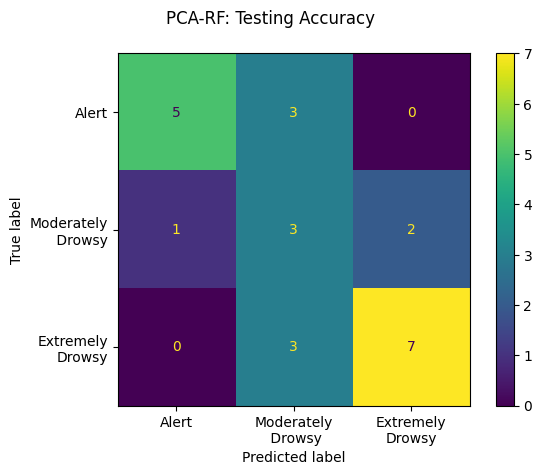

In [216]:
# PCA-KNN: Testing Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_rf_pca, 
                      pca_test_scaled, 
                      y_test,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("PCA-RF: Testing Accuracy")
plt.tight_layout()
plt.show()


In [217]:
# PCA-KNN: Testing Accuracy
classwise_accuracy(clf_rf_pca, pca_test_scaled, y_test)

Accuracy of Alert: 62.5000%
Accuracy of Moderately Drowsy: 50.0000%
Accuracy of Extremely Drowsy: 70.0000%
----------------------------------------
Micro-average F1: 62.5000%
Weighted-average F1: 64.5113%
Macro-average F1: 61.7043%


In [218]:
# Result Summary: RF-PCA (training)
result_summary(clf_rf_pca, X_train, pca_train_scaled, y_train)

,Original Index,Original Label,Predicted Label,True/False
2,2,1.0,1.0,True
3,3,1.0,1.0,True
4,4,1.0,1.0,True
5,5,1.0,2.0,False
6,6,1.0,1.0,True
...,...,...,...,...
113,113,3.0,3.0,True
114,114,3.0,3.0,True
115,115,3.0,3.0,True
116,116,3.0,3.0,True


In [219]:
# Result Summary: KNN-PCA (testing)
result_summary(clf_rf_pca, X_test, pca_test_scaled, y_test)

,Original Index,Original Label,Predicted Label,True/False
0,0,1.0,1.0,True
1,1,1.0,2.0,False
12,12,1.0,1.0,True
17,17,1.0,1.0,True
32,32,1.0,2.0,False
33,33,1.0,1.0,True
36,36,1.0,2.0,False
38,38,1.0,1.0,True
43,43,2.0,2.0,True
60,60,2.0,2.0,True
